# <font color=yellow>Transfer Learning</font> for Font-type Recognition with [Keras](https://keras.io/)</font>

<img src="https://s3.amazonaws.com/keras.io/img/keras-logo-2018-large-1200.png" alt="Keras logo" height="100" width="250"> 

---

# * [MSTC](http://mstc.ssr.upm.es/big-data-track) and MUIT: <font size=5 color='green'>Deep Learning</font>

* <font size=5 color='green'>Machine Learning Lab (MLLB)</font>
 
---
---


In [ ]:
import keras

from keras.utils import to_categorical

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

      
print('Keras version: ',keras.__version__)

Keras version:  2.4.3


## <font color= #00cc00>Next cells load the Font Type dataset:</font>


In [ ]:
"""
Load and data
"""

import os
from six.moves import urllib

file_url = 'https://github.com/bloolizard/PlayWithTensorFlow/raw/master/data_with_labels.npz'
file_name = 'data_with_labels.npz'

if not os.path.exists(file_name):
    urllib.request.urlretrieve(file_url, file_name)
    
    
# Load data
data = np.load('data_with_labels.npz')

images = data['arr_0']/255.
labels = data['arr_1']

onehot= to_categorical(labels, num_classes=len(np.unique(labels)))

## Preparing Train/Test Data :
- ### Random Permutation! + split data into training / validation

In [ ]:
# Split data into training (90%) and validation (10%)
np.random.seed(100)

indices = np.random.permutation(images.shape[0])

valid_cnt = int(images.shape[0] * 0.1)

test_idx, training_idx = indices[:valid_cnt],\
                         indices[valid_cnt:]
  
test_ori, train_ori = images[test_idx,:],\
              images[training_idx,:]
  
onehot_test, onehot_train = onehot[test_idx,:],\
                        onehot[training_idx,:]


In [ ]:
train_ori=train_ori.reshape([-1,train_ori.shape[1],train_ori.shape[2]])
test_ori=test_ori.reshape([-1,test_ori.shape[1],test_ori.shape[2]])

print('Train images ORIGINAL shape=', train_ori.shape , '\nTest images ORIGINAL shape=', test_ori.shape)

Train images ORIGINAL shape= (2511, 36, 36) 
Test images ORIGINAL shape= (279, 36, 36)


#<font color=yellow> Resize your images to have: 3 channels (RGB) and same dimensions as the Pre-trained network you are going to use
  
  

In [ ]:
from skimage.transform import resize
from skimage.color import gray2rgb 

# 224 x 224 for VGG
hori=224
vert=224

train = np.zeros((train_ori.shape[0],hori,vert,3))
test = np.zeros((test_ori.shape[0],hori,vert,3))

for n,i in enumerate(train_ori):
    new_img = gray2rgb(train_ori[n,:,:])
    train[n,:,:,:] = resize(new_img, train.shape[1:], anti_aliasing=True)
    
    

for n,i in enumerate(test_ori):
    new_img = gray2rgb(test_ori[n,:,:])
    test[n,:,:,:] = resize(new_img, test.shape[1:], anti_aliasing=True)
    
    

In [ ]:
print('Train images shape=', train.shape , '\nTest images shape=', test.shape)

Train images shape= (2511, 224, 224, 3) 
Test images shape= (279, 224, 224, 3)


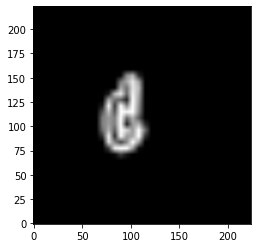

In [ ]:
plt.imshow(train[2000,:,:,:], origin='lower')

---
<font size=6 color=yellow>BUILD the "transfer learning" Model:</font><br>
- <font size=4 > We can try with many pre-trained Models:</font><br><br>
-- <font size=4>We will try a simple Model</font><font size=4 color='orange'> **VGG16**</font><br>
-- <font size=4> ...but there are many : </font> **Xception, InceptionV3, or ResNet50**

---

In [ ]:
from keras import applications

# In this way input tensor shape is forced
# to be (224, 224, 3)

vgg_model = applications.VGG16(weights='imagenet', include_top=True)


################## Change the VGG model ###################################################################
#vgg_model = applications.xception.Xception(include_top=True, weights='imagenet', input_tensor=None, input_shape=(299, 299, 3), pooling=None, classes=1000)
#vgg_model = applications.inception_v3.InceptionV3(include_top=True, weights='imagenet', input_tensor=None, input_shape=(299, 299, 3), pooling=None, classes=1000)
#vgg_model = applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=(224, 224, 3), pooling=None, classes=1000)


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

- ## We can remove the last added layer in a Sequential model by calling .pop():

In [ ]:
# Note that if you call it several times you remove the last after the previous 

vgg_model._layers.pop()
vgg_model._layers.pop()
vgg_model._layers.pop()


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

---
---

## <font size= 6 color=yellow>Now we use KERAS API</font>

---


## We can add some more layers (we only add one softmax):
##- `vgg_model.layers[-1].output` is the last output of VGG16 (after pop-ing out the last layers)


In [ ]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Model


x = Dropout(rate=0.4)(vgg_model.layers[-1].output)
x = Dense(64, activation='relu')(x)  # new softmax layer
predictions = Dense(5, activation='softmax', name='softmax_new1')(x)  # new softmax layer
transfer_model = Model(vgg_model.input, predictions)

In [ ]:
transfer_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# We can <font color=red>Freeze</font> Layers <font color=green> ... or NOT</font>

In [ ]:
# Make sure that the pre-trained bottom layers are not trainable

for layer in vgg_model.layers:
        layer.trainable = False
vgg_model.layers[1].trainable = True

# COMPILE... as usual

In [ ]:
import keras


transfer_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])

## You can check which layers are trainable...

In [ ]:
for i in range(1, len(transfer_model.layers)):
    print('Layer: ' , i, 'Trainable: ', transfer_model.layers[i].trainable)


Layer:  1 Trainable:  True
Layer:  2 Trainable:  True
Layer:  3 Trainable:  True
Layer:  4 Trainable:  True
Layer:  5 Trainable:  True
Layer:  6 Trainable:  True
Layer:  7 Trainable:  True
Layer:  8 Trainable:  True
Layer:  9 Trainable:  True
Layer:  10 Trainable:  True
Layer:  11 Trainable:  True
Layer:  12 Trainable:  True
Layer:  13 Trainable:  True
Layer:  14 Trainable:  True
Layer:  15 Trainable:  True
Layer:  16 Trainable:  True
Layer:  17 Trainable:  True
Layer:  18 Trainable:  True
Layer:  19 Trainable:  True
Layer:  20 Trainable:  True
Layer:  21 Trainable:  True
Layer:  22 Trainable:  True


In [ ]:
transfer_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

# TRAIN...

# 3.   **Fit your model**. Train the model using data.

In [ ]:
# history to analyze training history evolution

# validation_data allows to see evaluation on test while training
history=transfer_model.fit(train, onehot_train,
         epochs=50,
         batch_size=128,
         validation_data=(test, onehot_test),
         verbose=1)

Epoch 1/50
20/20 [==============================] - 39s 2s/step - loss: 3943.3839 - accuracy: 0.2127 - val_loss: 1.6081 - val_accuracy: 0.2007
Epoch 2/50
20/20 [==============================] - 35s 2s/step - loss: 1.6098 - accuracy: 0.2026 - val_loss: 1.6112 - val_accuracy: 0.1720
Epoch 3/50
20/20 [==============================] - 33s 2s/step - loss: 1.6101 - accuracy: 0.2064 - val_loss: 1.6105 - val_accuracy: 0.1720
Epoch 4/50
20/20 [==============================] - 35s 2s/step - loss: 1.6097 - accuracy: 0.1957 - val_loss: 1.6096 - val_accuracy: 0.1720
Epoch 5/50
20/20 [==============================] - 33s 2s/step - loss: 1.6095 - accuracy: 0.2040 - val_loss: 1.6107 - val_accuracy: 0.1720
Epoch 6/50
20/20 [==============================] - 33s 2s/step - loss: 1.6096 - accuracy: 0.1939 - val_loss: 1.6106 - val_accuracy: 0.1541
Epoch 7/50
20/20 [==============================] - 32s 2s/step - loss: 1.6094 - accuracy: 0.1938 - val_loss: 1.6108 - val_accuracy: 0.1541
Epoch 8/50
20/20 

## 4.   **Make predictions**. Use the model to generate predictions on new data.

In [ ]:
# Check accuracy on train set

loss_train, accuracy_train = transfer_model.evaluate(train, onehot_train, batch_size=128)


print('\nTraining Accuracy=', accuracy_train)

# Check accuracy on test set

loss, accuracy = transfer_model.evaluate(test, onehot_test, batch_size=128)


print('\nTest Accuracy=', accuracy)

20/20 [==============================] - 9s 451ms/step - loss: 1.6092 - accuracy: 0.2051

Training Accuracy= 0.20509757101535797
3/3 [==============================] - 1s 299ms/step - loss: 1.6131 - accuracy: 0.1541

Test Accuracy= 0.15412186086177826


In [ ]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Train Accuracy:  0.21
Test_Accuracy:  0.15


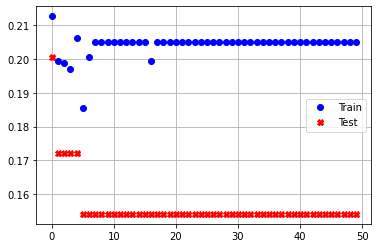

In [ ]:
print('Train Accuracy: ',np.round(history.history['accuracy'][-1],2))
print('Test_Accuracy: ',np.round(history.history['val_accuracy'][-1],2))

# Plot the accuracy curves
plt.plot(history.history['accuracy'],'bo')
plt.plot(history.history['val_accuracy'],'rX')
plt.grid()
plt.legend(['Train','Test'])

# Get predictions / probabilities ...

In [ ]:
pred_probabilities= transfer_model.predict(test)

print('First Five Probs.:\n',pred_probabilities[0:5])

print('\n\nFirst Five Classes:\n',onehot_test[0:5])

First Five Probs.:
 [[0.1978988  0.19388567 0.2029451  0.20527443 0.19999607]
 [0.1978988  0.19388567 0.2029451  0.20527443 0.19999607]
 [0.1978988  0.19388567 0.2029451  0.20527443 0.19999607]
 [0.1978988  0.19388567 0.2029451  0.20527443 0.19999607]
 [0.1978988  0.19388567 0.2029451  0.20527443 0.19999607]]


First Five Classes:
 [[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


## Confusion Matrix

Confusion Matrix:
 [[ 0  0  0 61  0]
 [ 0  0  0 71  0]
 [ 0  0  0 48  0]
 [ 0  0  0 43  0]
 [ 0  0  0 56  0]]


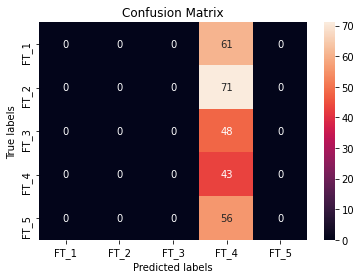

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix as cm

ConfMatrix=cm(np.argmax(onehot_test,1), np.argmax(pred_probabilities,1))

print('Confusion Matrix:\n',ConfMatrix)

ax= plt.subplot()
sns.heatmap(ConfMatrix, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')

ax.xaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5'])
ax.yaxis.set_ticklabels(['FT_1', 'FT_2','FT_3','FT_4','FT_5']);

[[0. 0. 0. 1. 0.]]
input_1 (1, 224, 224, 3) 


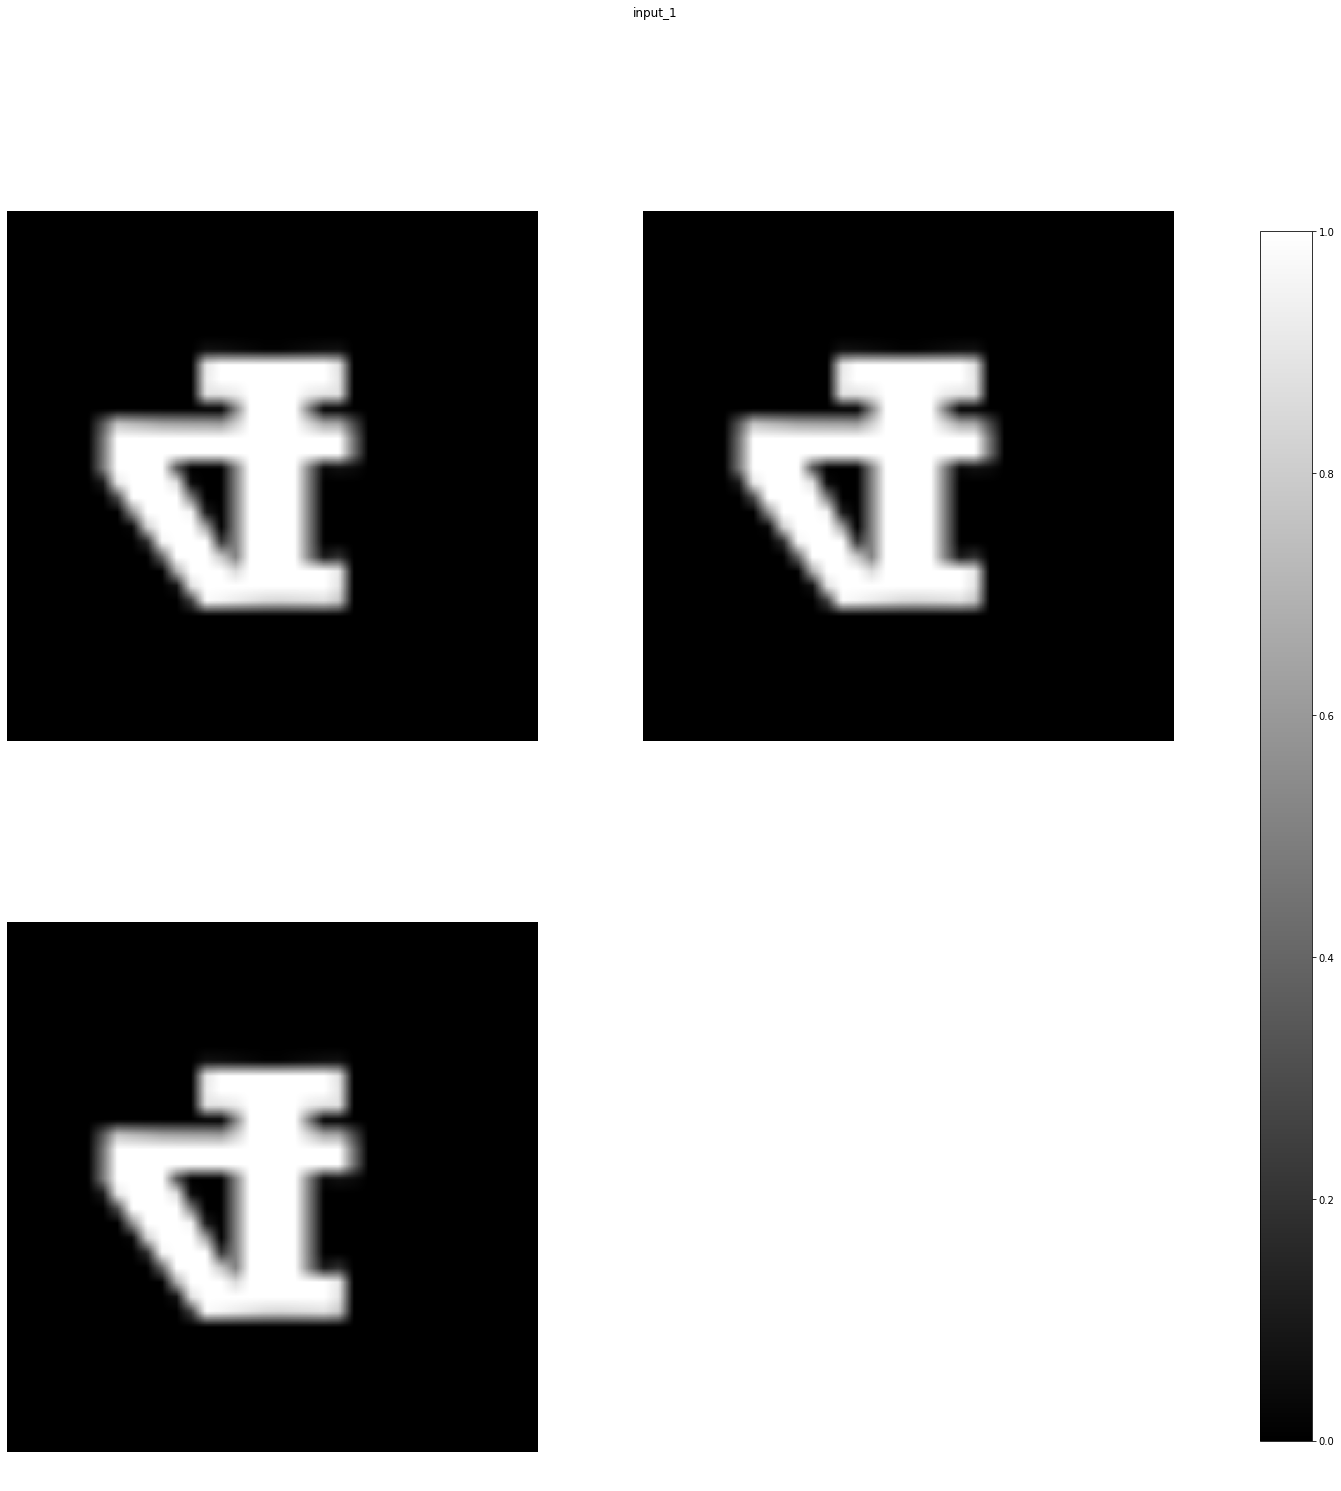

block1_conv1 (1, 224, 224, 64) 


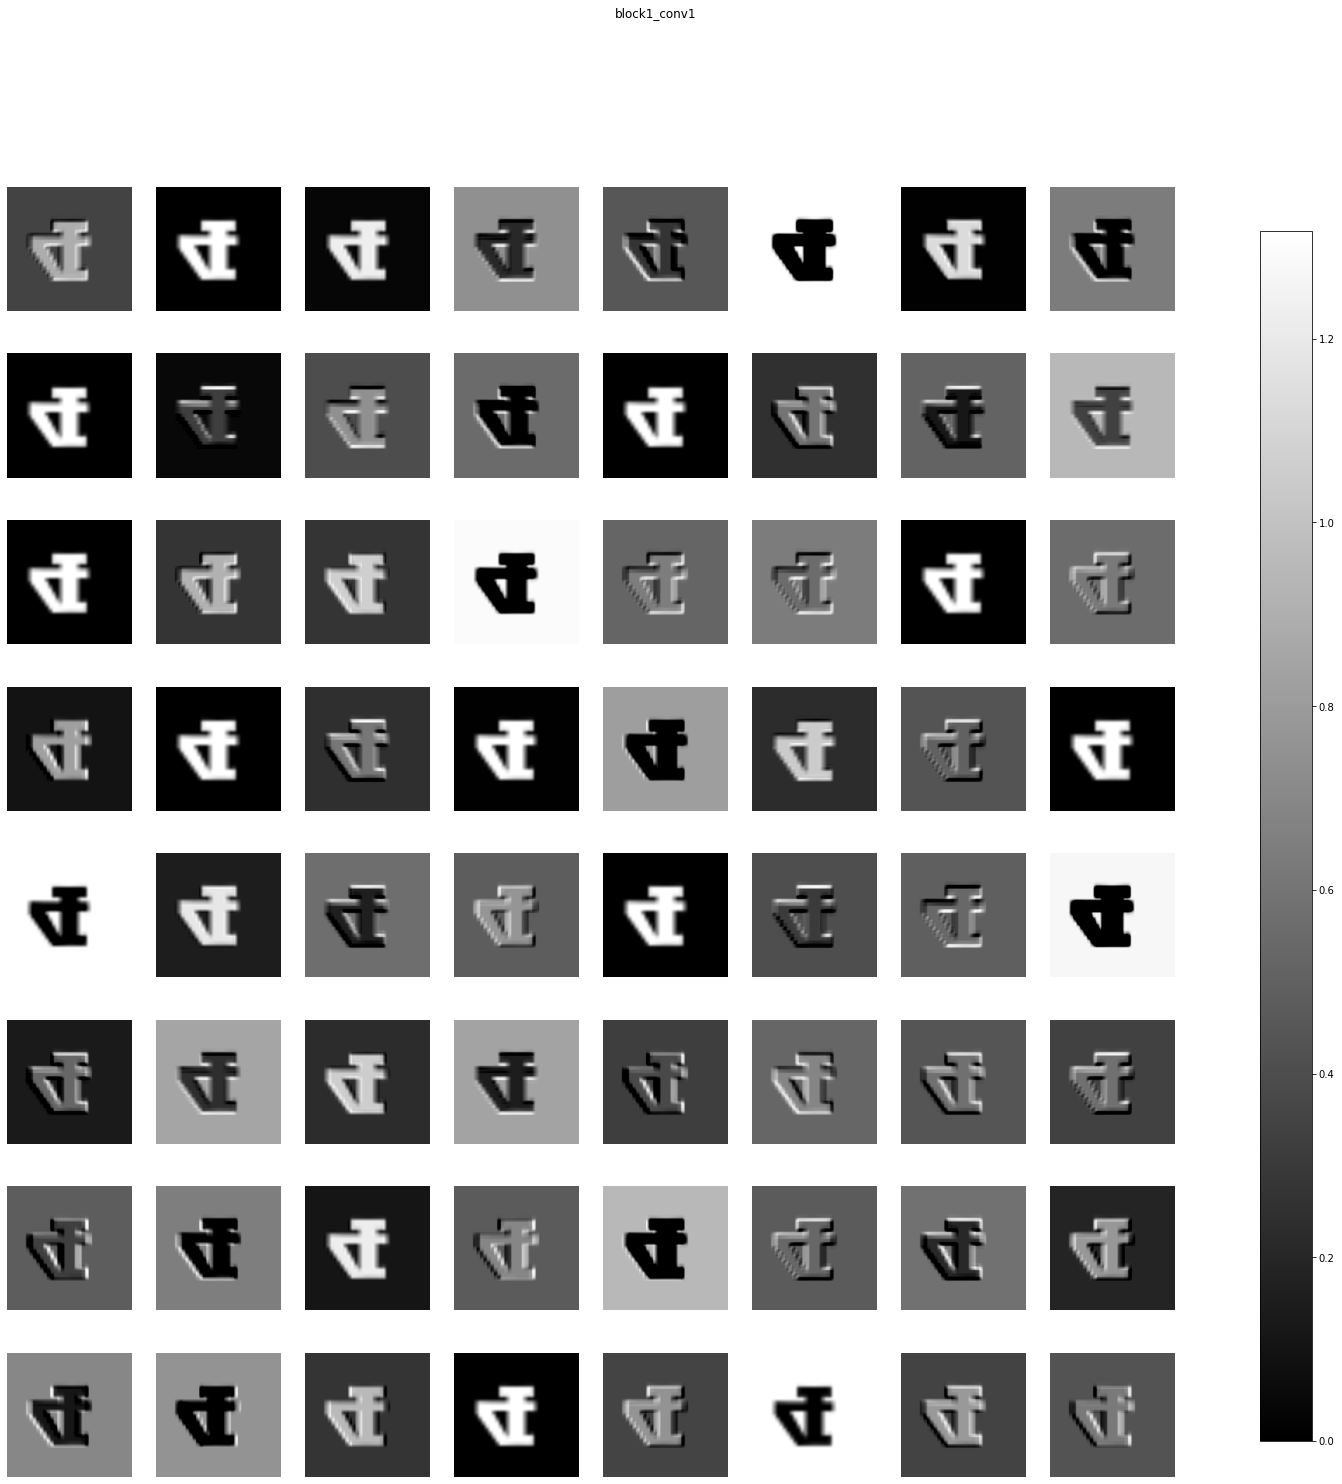

block1_conv2 (1, 224, 224, 64) 


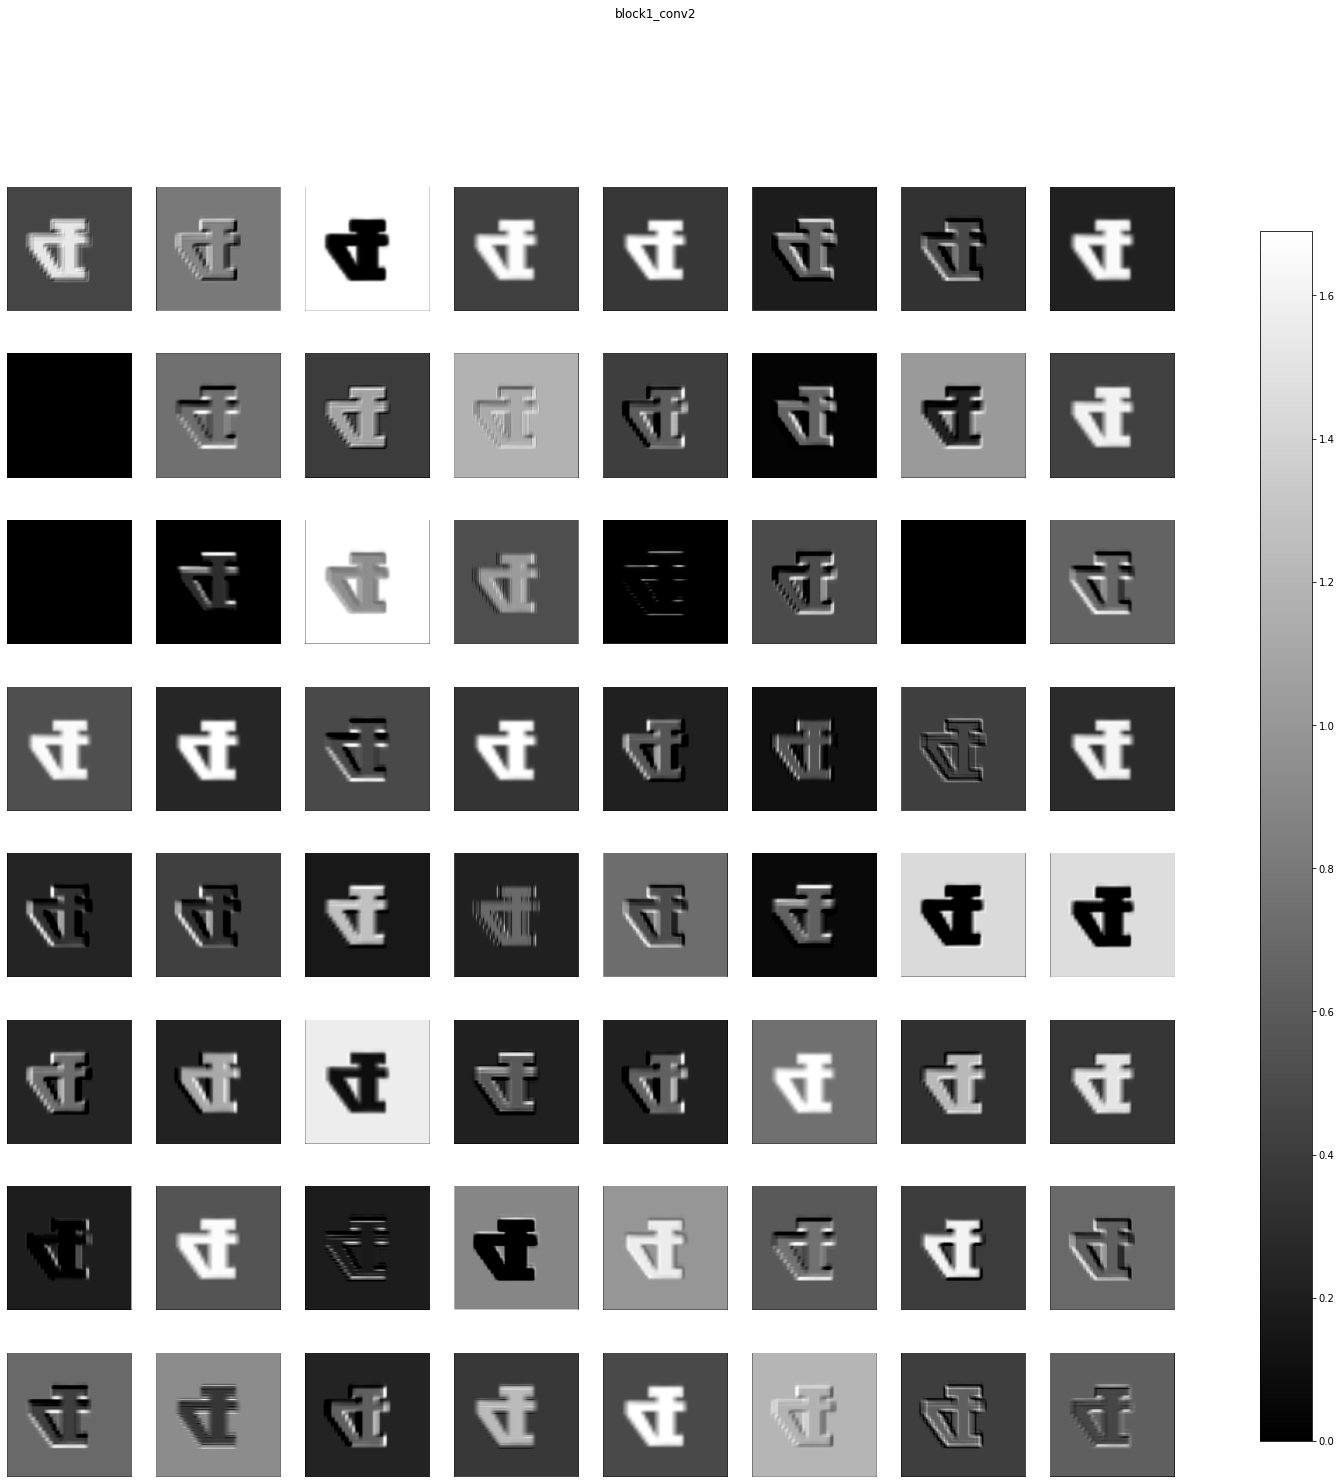

block1_pool (1, 112, 112, 64) 


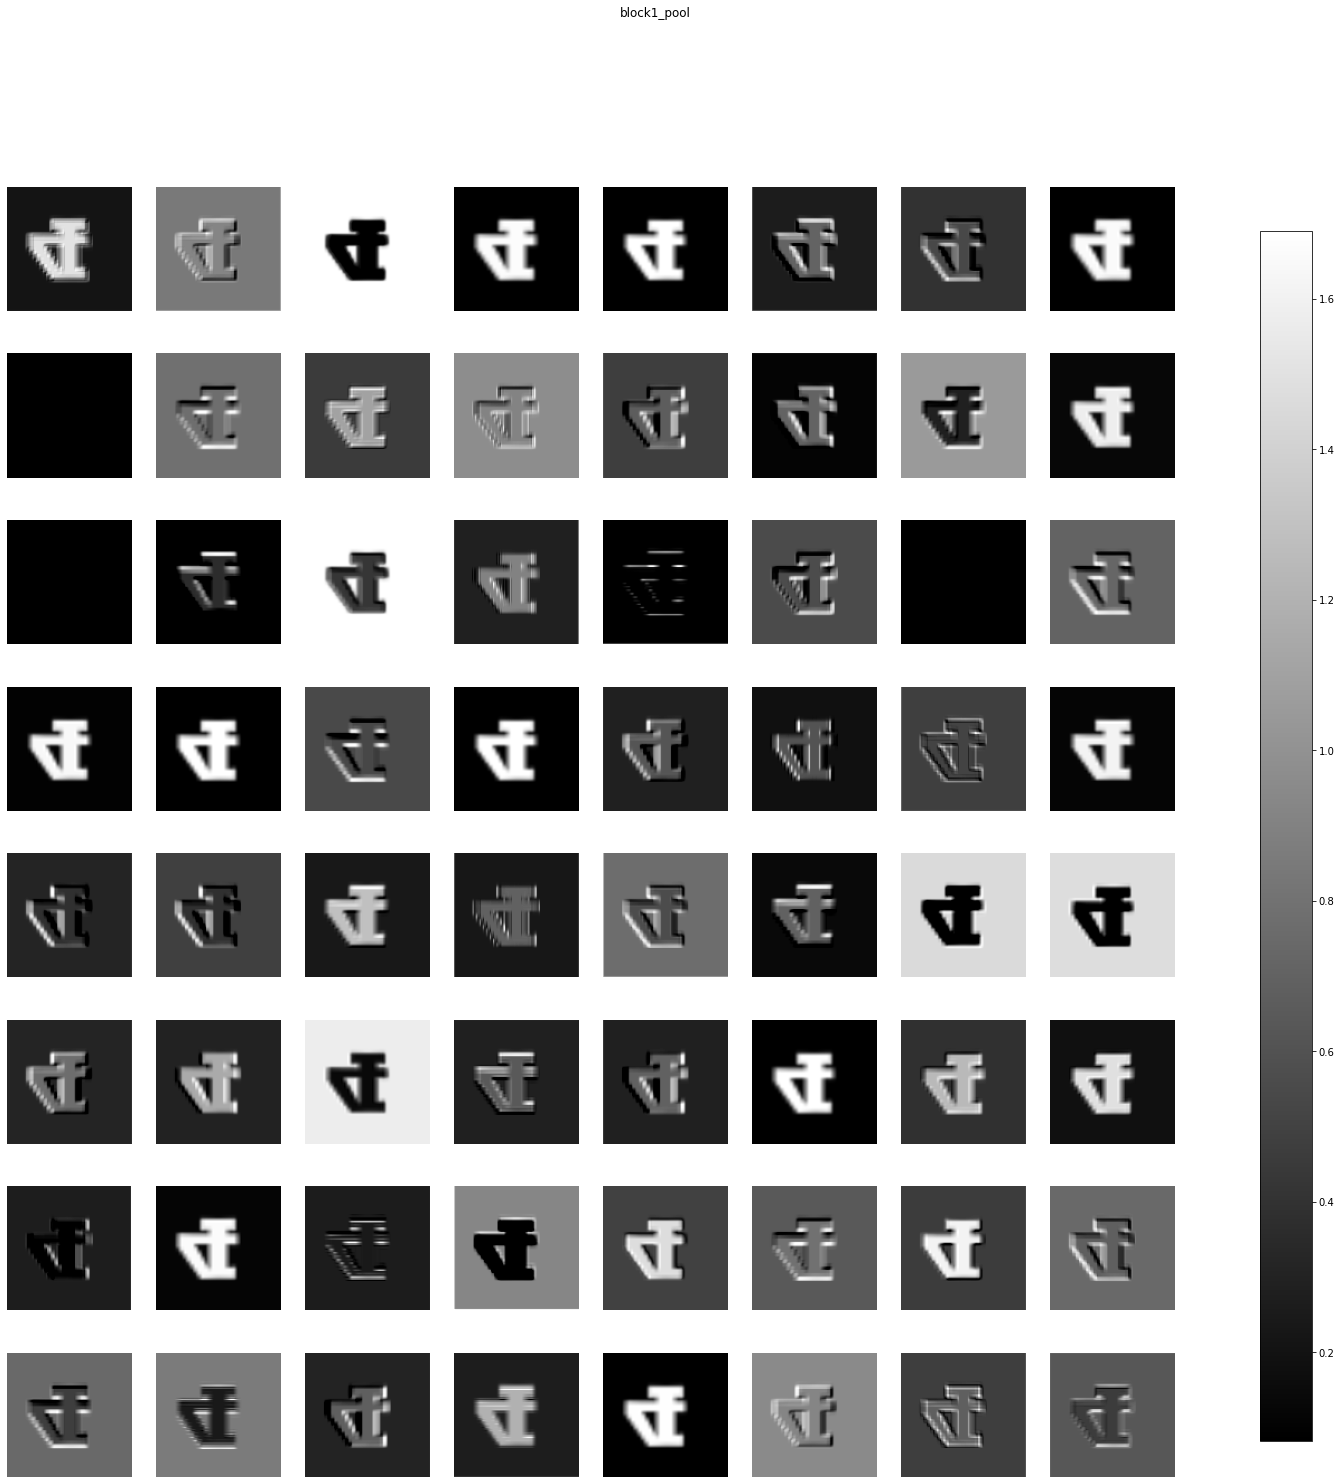

block2_conv1 (1, 112, 112, 128) 


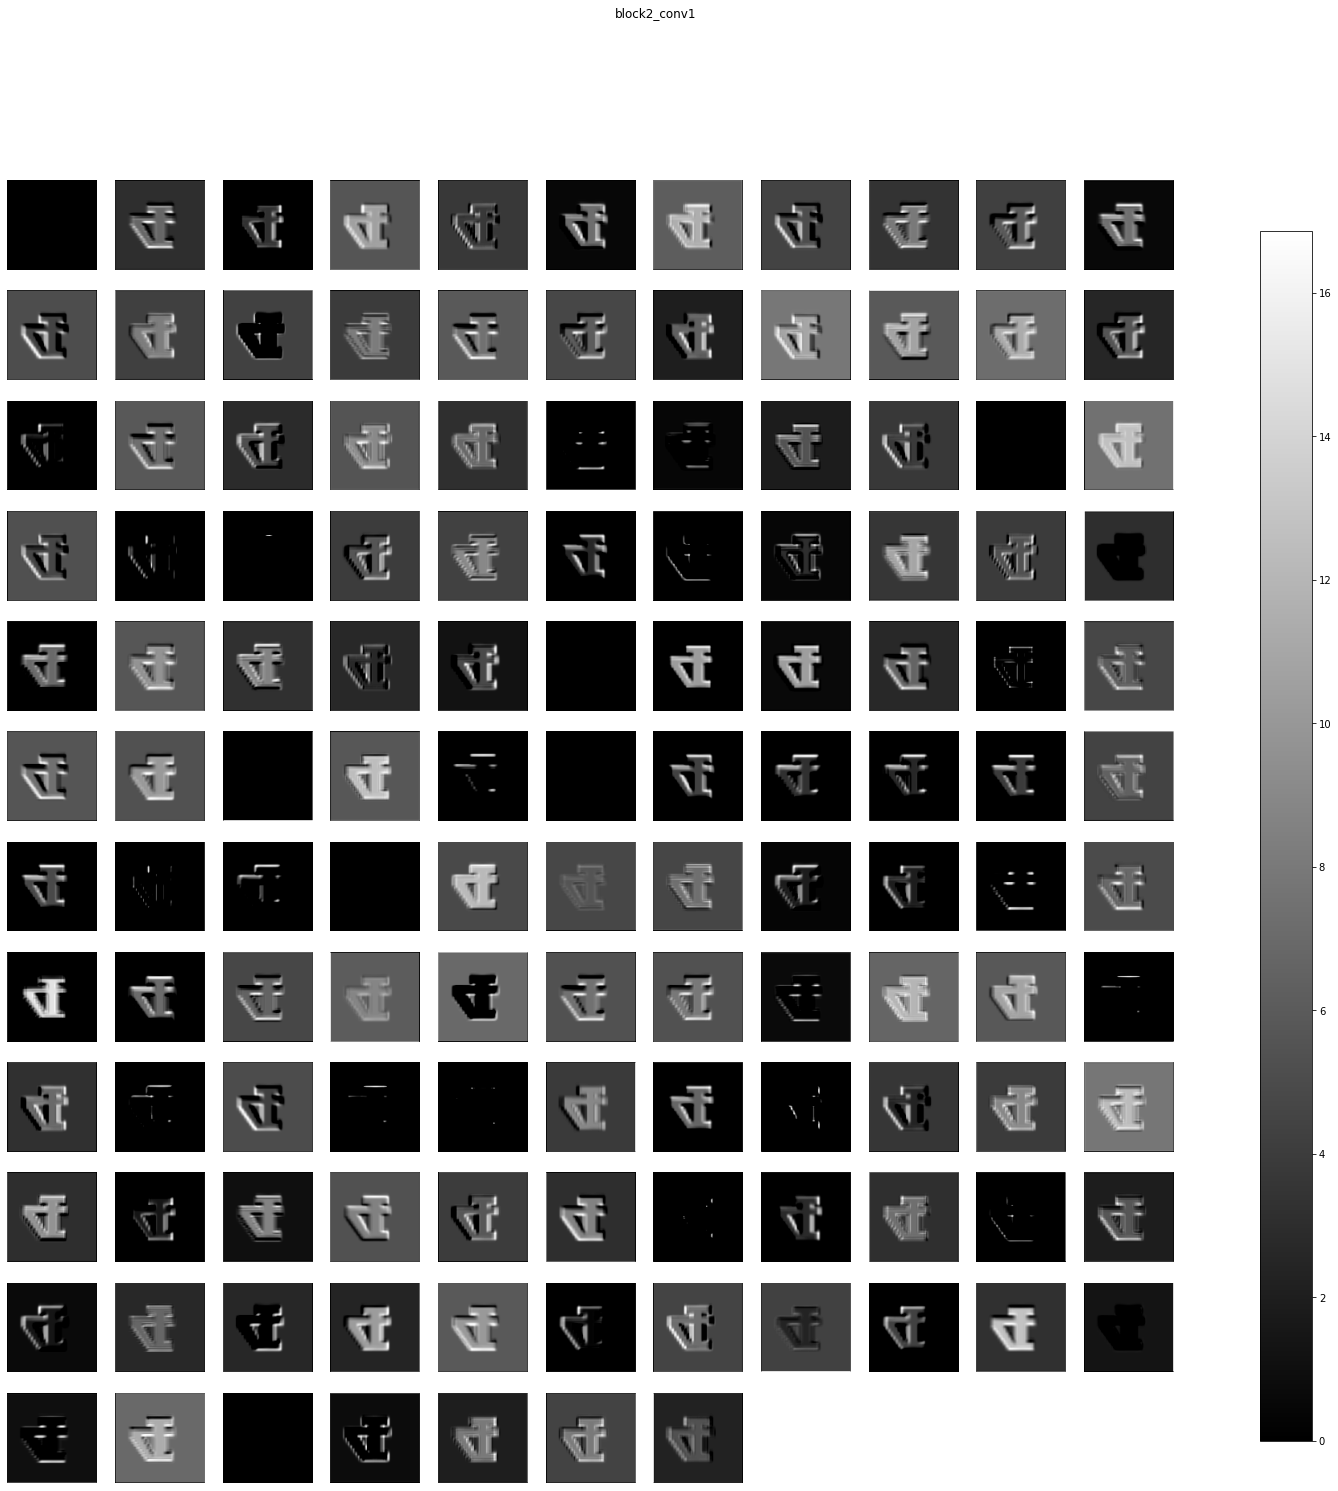

block2_conv2 (1, 112, 112, 128) 


KeyboardInterrupt: ignored

In [ ]:
# =============================================
# Keract visualizations
# =============================================
!pip install keract
from keract import get_activations, display_activations
keract_inputs = test[32:33]
activations = get_activations(transfer_model, keract_inputs)
display_activations(activations, cmap="gray", save=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 0 --------------------------


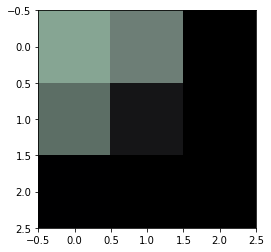

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 1 --------------------------


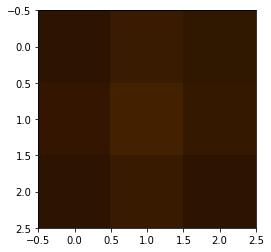

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 2 --------------------------


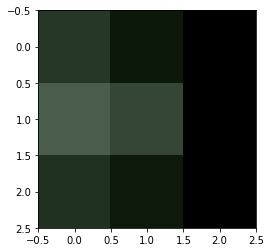

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 3 --------------------------


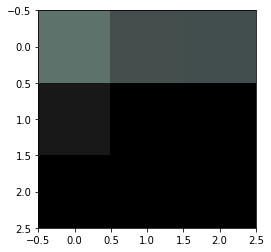

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 4 --------------------------


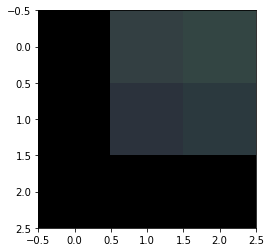

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 5 --------------------------


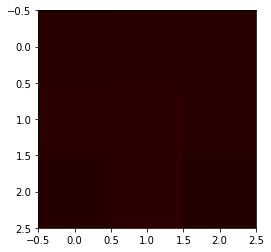

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 6 --------------------------


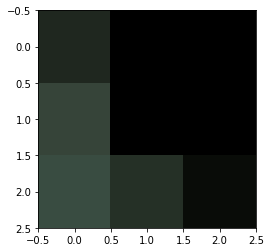

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 7 --------------------------


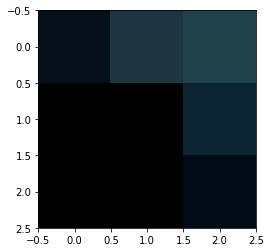

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 8 --------------------------


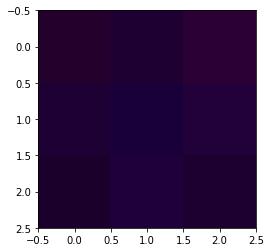

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 9 --------------------------


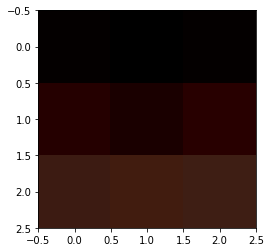

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 10 --------------------------


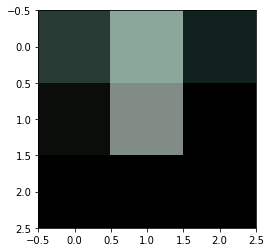

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 11 --------------------------


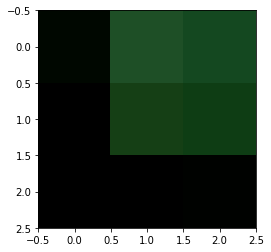

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 12 --------------------------


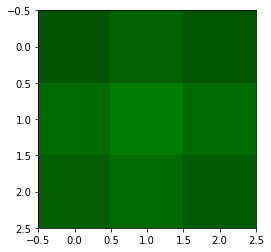

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 13 --------------------------


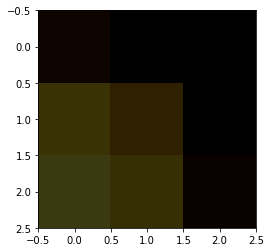

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 14 --------------------------


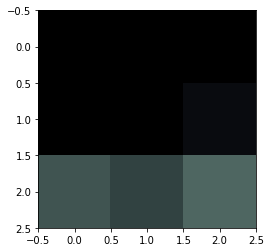

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 15 --------------------------


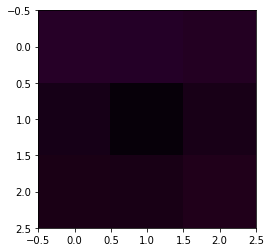

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 16 --------------------------


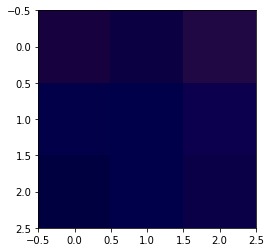

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 17 --------------------------


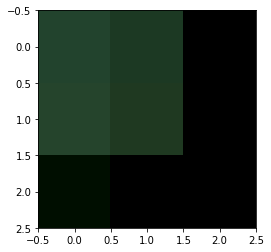

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 18 --------------------------


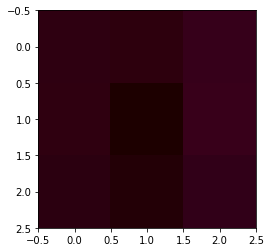

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 19 --------------------------


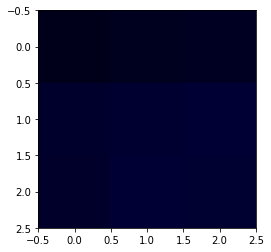

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 20 --------------------------


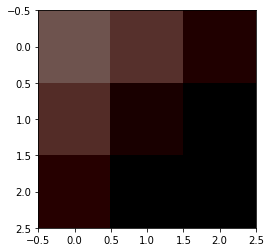

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 21 --------------------------


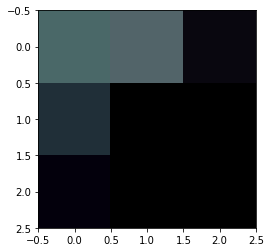

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 22 --------------------------


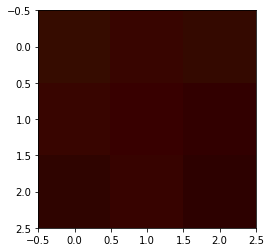

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 23 --------------------------


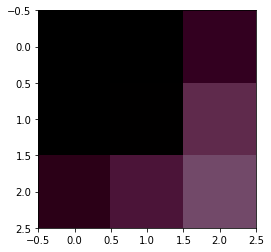

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 24 --------------------------


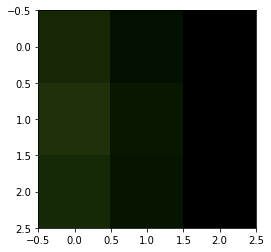

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 25 --------------------------


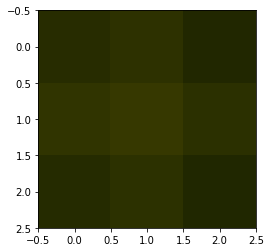

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 26 --------------------------


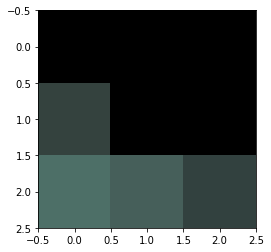

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 27 --------------------------


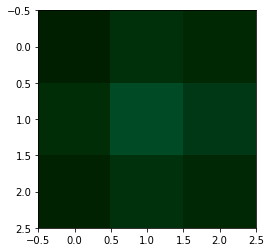

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 28 --------------------------


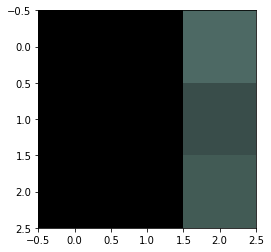

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 29 --------------------------


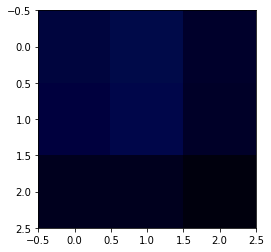

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 30 --------------------------


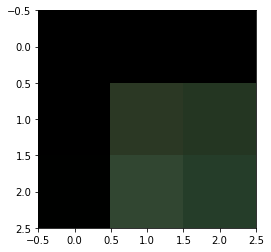

------------- 31 --------------------------


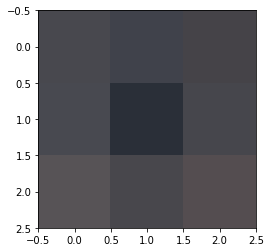

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 32 --------------------------


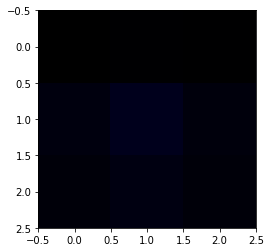

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 33 --------------------------


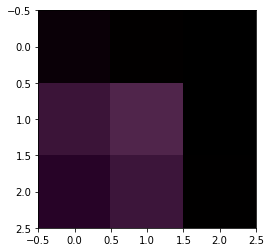

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 34 --------------------------


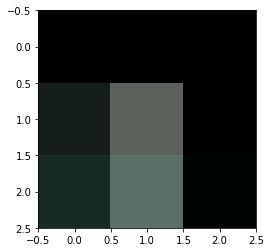

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 35 --------------------------


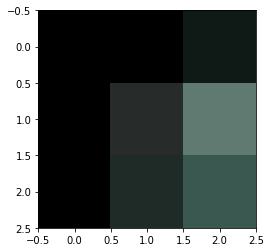

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 36 --------------------------


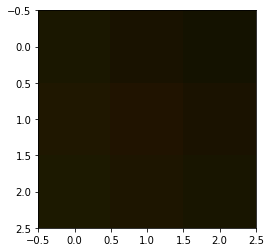

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 37 --------------------------


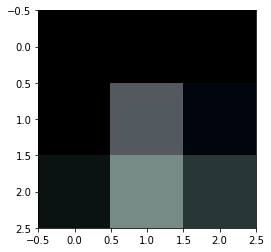

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 38 --------------------------


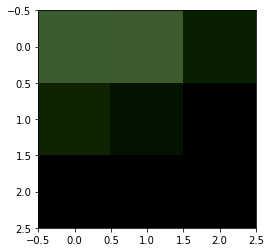

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 39 --------------------------


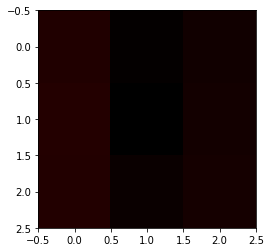

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 40 --------------------------


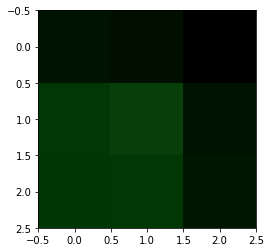

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 41 --------------------------


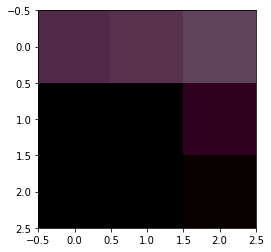

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 42 --------------------------


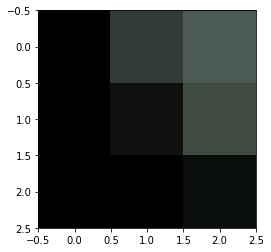

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 43 --------------------------


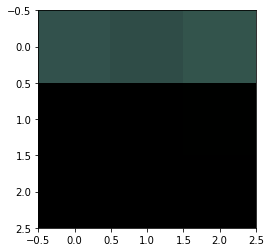

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 44 --------------------------


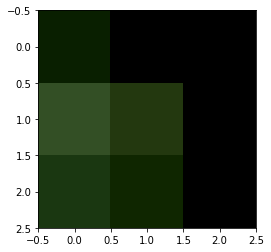

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 45 --------------------------


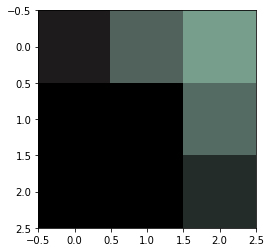

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 46 --------------------------


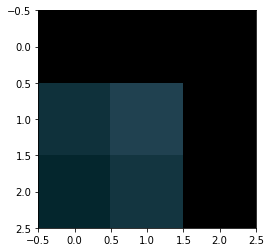

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 47 --------------------------


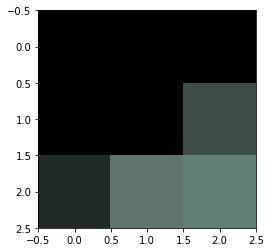

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 48 --------------------------


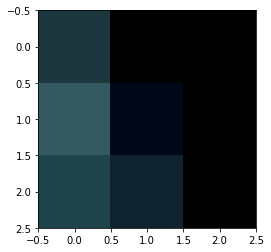

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 49 --------------------------


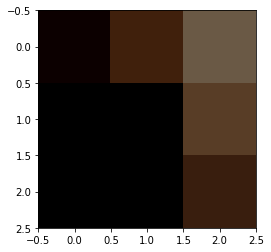

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 50 --------------------------


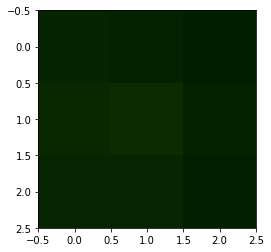

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 51 --------------------------


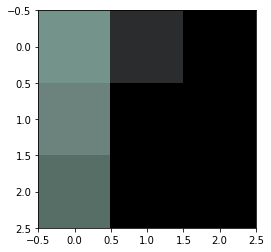

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 52 --------------------------


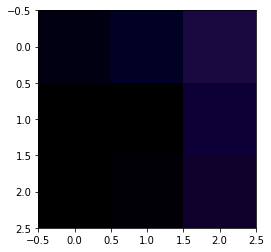

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 53 --------------------------


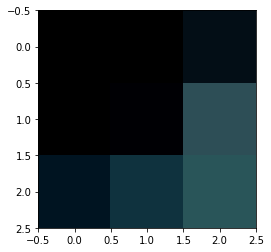

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 54 --------------------------


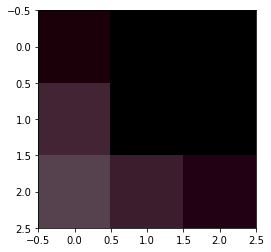

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 55 --------------------------


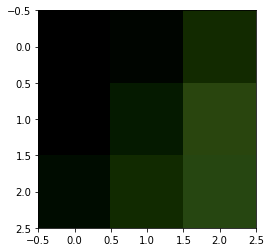

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 56 --------------------------


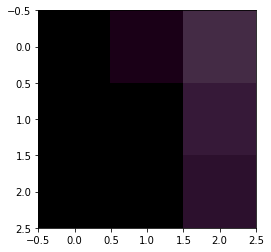

------------- 57 --------------------------


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


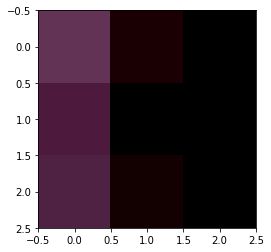

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 58 --------------------------


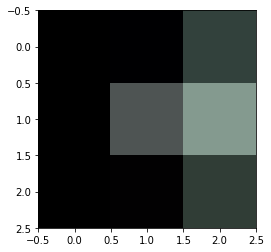

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 59 --------------------------


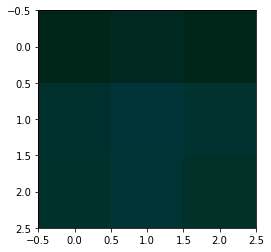

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 60 --------------------------


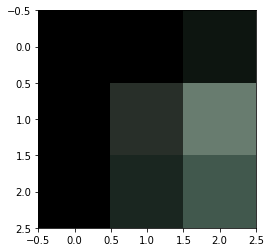

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 61 --------------------------


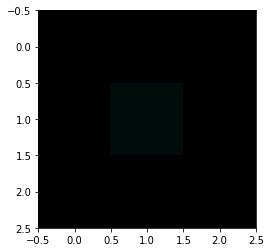

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 62 --------------------------


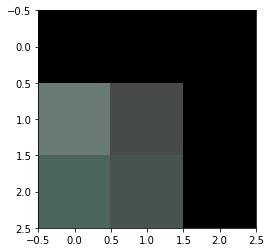

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------- 63 --------------------------


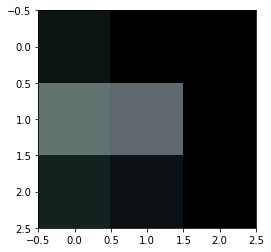

In [ ]:
weight = transfer_model.layers[1].get_weights()[0]
import matplotlib.pyplot as plt
for i in range(64):
  print("-------------",i,"--------------------------")
  plt.imshow(weight[:,:,:,i])
  plt.show()

In [ ]:
vgg_model2 = applications.VGG16(weights='imagenet', include_top=True)

------------- 0 --------------------------
0.0


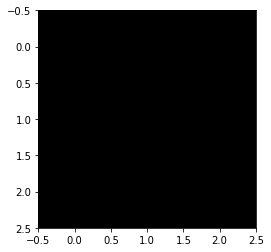

------------- 1 --------------------------
0.0


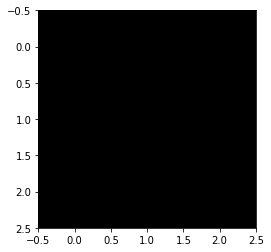

------------- 2 --------------------------
0.0


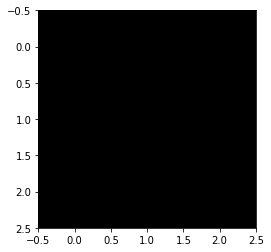

------------- 3 --------------------------
0.0


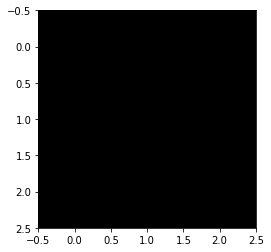

------------- 4 --------------------------
0.0


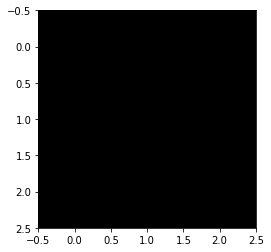

------------- 5 --------------------------
0.0


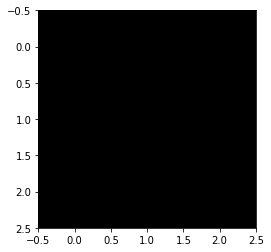

------------- 6 --------------------------
0.0


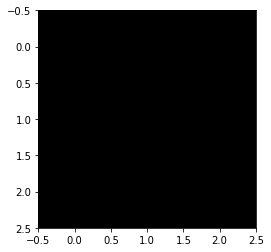

------------- 7 --------------------------
0.0


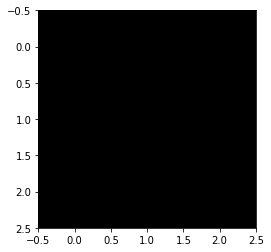

------------- 8 --------------------------
0.0


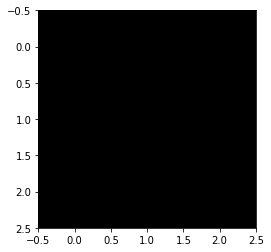

------------- 9 --------------------------
0.0


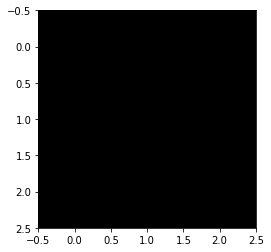

------------- 10 --------------------------
0.0


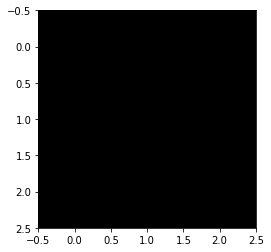

------------- 11 --------------------------
0.0


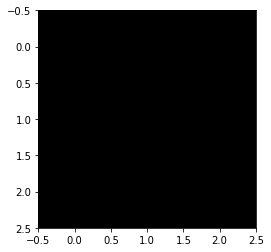

------------- 12 --------------------------
0.0


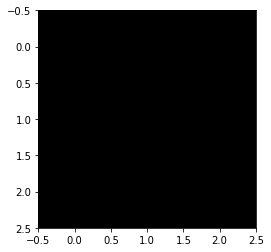

------------- 13 --------------------------
0.0


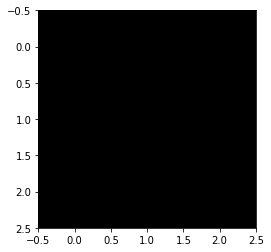

------------- 14 --------------------------
0.0


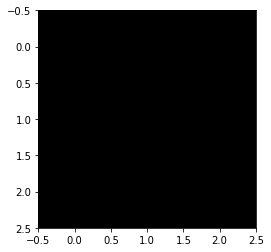

------------- 15 --------------------------
0.0


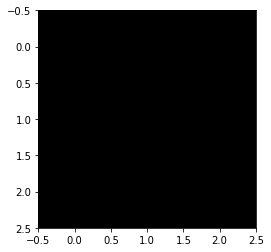

------------- 16 --------------------------
0.0


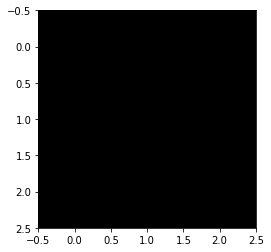

------------- 17 --------------------------
0.0


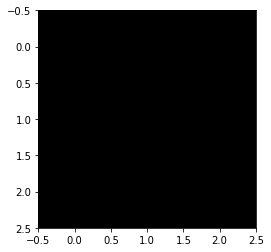

------------- 18 --------------------------
0.0


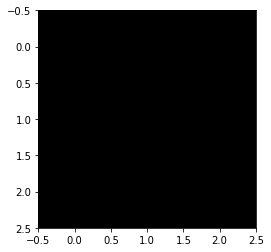

------------- 19 --------------------------
0.0


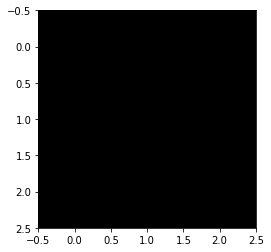

------------- 20 --------------------------
0.0


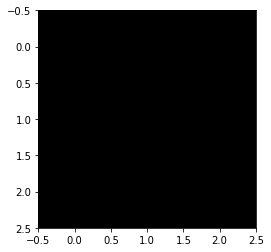

------------- 21 --------------------------
0.0


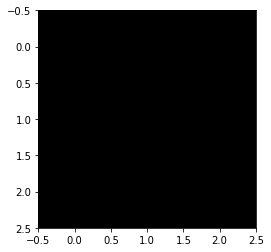

------------- 22 --------------------------
0.0


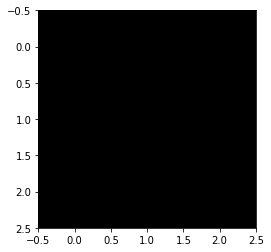

------------- 23 --------------------------
0.0


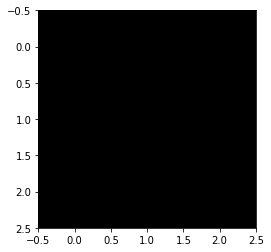

------------- 24 --------------------------
0.0


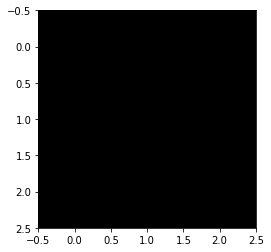

------------- 25 --------------------------
0.0


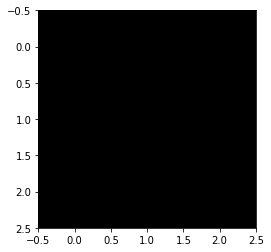

------------- 26 --------------------------
0.0


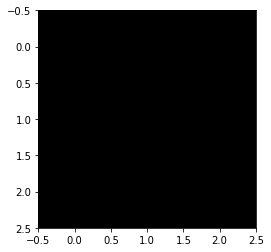

------------- 27 --------------------------
0.0


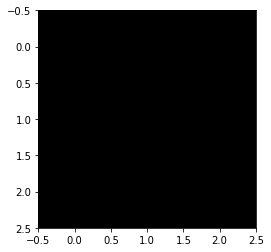

------------- 28 --------------------------
0.0


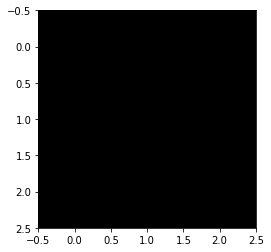

------------- 29 --------------------------
0.0


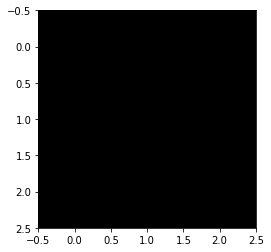

------------- 30 --------------------------
0.0


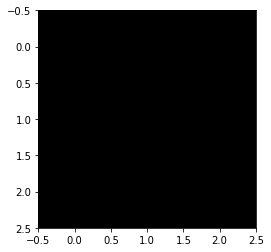

------------- 31 --------------------------
0.0


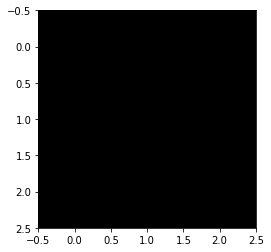

------------- 32 --------------------------
0.0


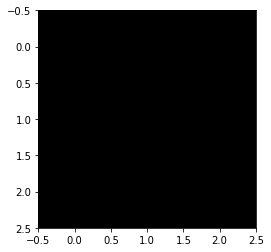

------------- 33 --------------------------
0.0


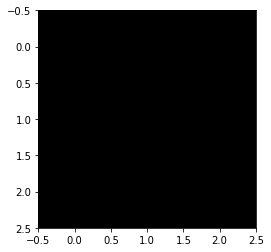

------------- 34 --------------------------
0.0


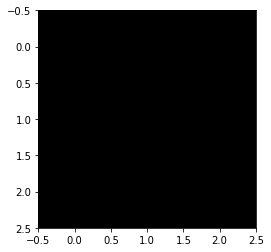

------------- 35 --------------------------
0.0


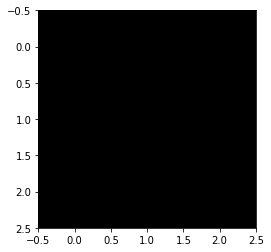

------------- 36 --------------------------
0.0


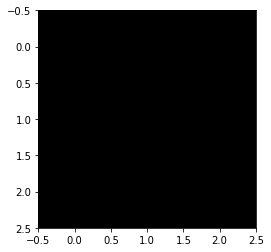

------------- 37 --------------------------
0.0


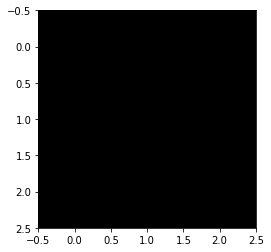

------------- 38 --------------------------
0.0


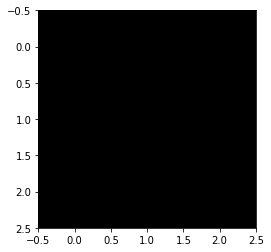

------------- 39 --------------------------
0.0


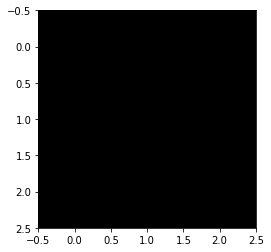

------------- 40 --------------------------
0.0


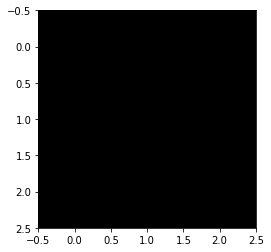

------------- 41 --------------------------
0.0


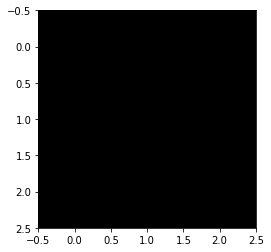

------------- 42 --------------------------
0.0


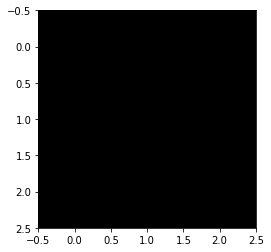

------------- 43 --------------------------
0.0


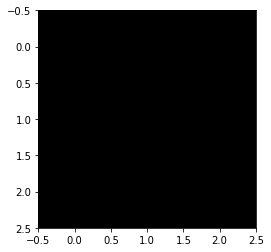

------------- 44 --------------------------
0.0


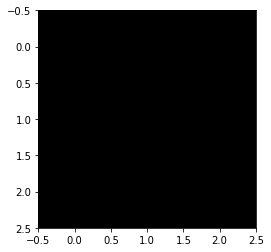

------------- 45 --------------------------
0.0


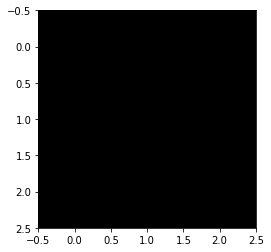

------------- 46 --------------------------
0.0


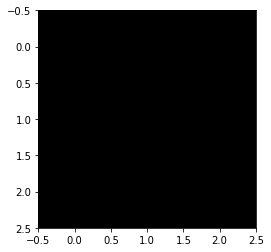

------------- 47 --------------------------
0.0


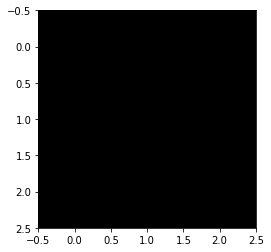

------------- 48 --------------------------
0.0


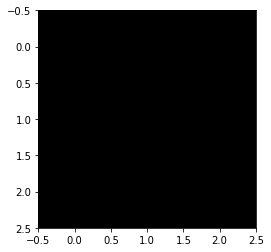

------------- 49 --------------------------
0.0


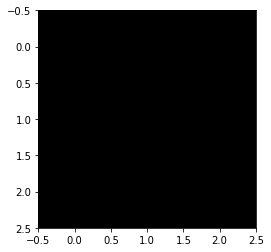

------------- 50 --------------------------
0.0


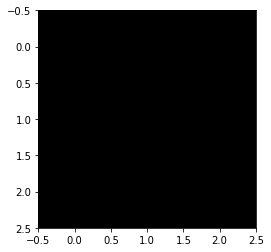

------------- 51 --------------------------
0.0


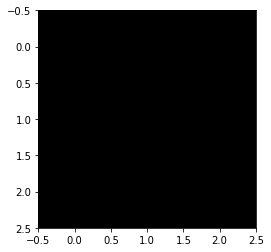

------------- 52 --------------------------
0.0


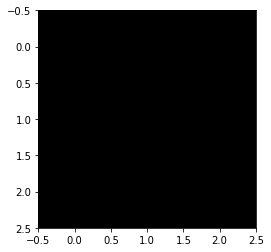

------------- 53 --------------------------
0.0


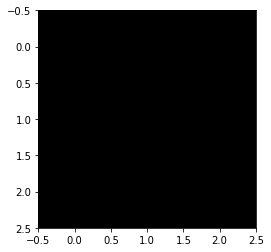

------------- 54 --------------------------
0.0


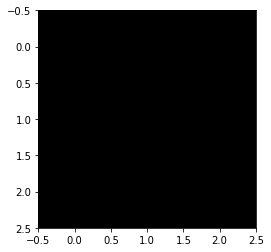

------------- 55 --------------------------
0.0


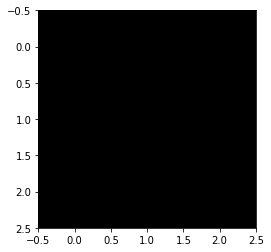

------------- 56 --------------------------
0.0


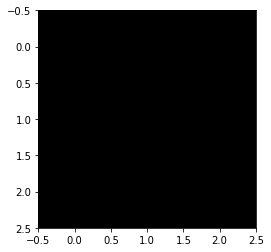

------------- 57 --------------------------
0.0


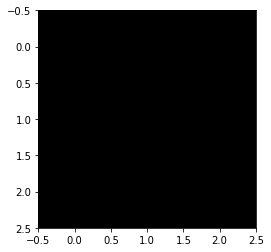

------------- 58 --------------------------
0.0


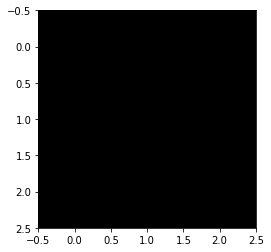

------------- 59 --------------------------
0.0


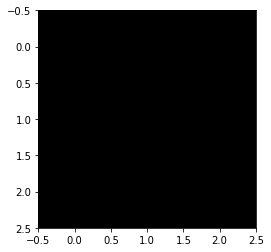

------------- 60 --------------------------
0.0


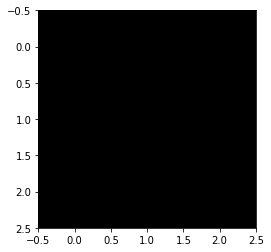

------------- 61 --------------------------
0.0


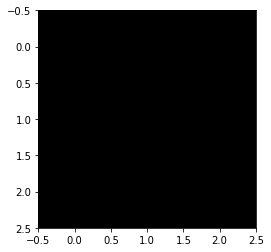

------------- 62 --------------------------
0.0


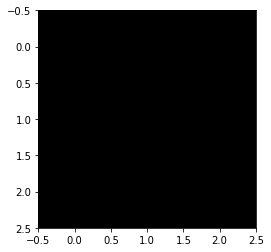

------------- 63 --------------------------
0.0


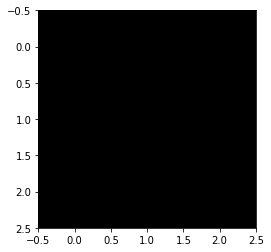

In [ ]:
weight2 = transfer_model.layers[1].get_weights()[0]
weight3 = weight2-weight
for i in range(64):
  print("-------------",i,"--------------------------")
  print(np.max(weight3))
  plt.imshow(weight3[:,:,:,i])
  plt.show()

In [ ]:
import keras
from keras.layers import Dense, Dropout
from keras.models import Model
base_model = keras.applications.resnet50.ResNet50(
    include_top=False, weights='imagenet',
    input_shape=(224,224,3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(5, activation= 'softmax')(x)


94773248/94765736 [==============================] - 3s 0us/step


In [ ]:

for layer in base_model.layers:
  layer.trainable = False
# Make sure that the pre-trained bottom layers are not trainable
model = keras.Model(inputs = base_model.input, outputs = predictions)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='rmsprop',
              metrics=['accuracy'])

for i in range(1, len(model.layers)):
    print('Layer: ' , i, 'Trainable: ', model.layers[i].trainable)


Layer:  1 Trainable:  False
Layer:  2 Trainable:  False
Layer:  3 Trainable:  False
Layer:  4 Trainable:  False
Layer:  5 Trainable:  False
Layer:  6 Trainable:  False
Layer:  7 Trainable:  False
Layer:  8 Trainable:  False
Layer:  9 Trainable:  False
Layer:  10 Trainable:  False
Layer:  11 Trainable:  False
Layer:  12 Trainable:  False
Layer:  13 Trainable:  False
Layer:  14 Trainable:  False
Layer:  15 Trainable:  False
Layer:  16 Trainable:  False
Layer:  17 Trainable:  False
Layer:  18 Trainable:  False
Layer:  19 Trainable:  False
Layer:  20 Trainable:  False
Layer:  21 Trainable:  False
Layer:  22 Trainable:  False
Layer:  23 Trainable:  False
Layer:  24 Trainable:  False
Layer:  25 Trainable:  False
Layer:  26 Trainable:  False
Layer:  27 Trainable:  False
Layer:  28 Trainable:  False
Layer:  29 Trainable:  False
Layer:  30 Trainable:  False
Layer:  31 Trainable:  False
Layer:  32 Trainable:  False
Layer:  33 Trainable:  False
Layer:  34 Trainable:  False
Layer:  35 Trainable:  

In [ ]:
# history to analyze training history evolution

# validation_data allows to see evaluation on test while training
history=model.fit(train, onehot_train,
         epochs=200,
         batch_size=128,
         validation_data=(test, onehot_test),
         verbose=1)

Epoch 1/200
20/20 [==============================] - 15s 316ms/step - loss: 2.1501 - accuracy: 0.1876 - val_loss: 1.5467 - val_accuracy: 0.3584
Epoch 2/200
20/20 [==============================] - 5s 229ms/step - loss: 1.7195 - accuracy: 0.2451 - val_loss: 1.4717 - val_accuracy: 0.4946
Epoch 3/200
20/20 [==============================] - 5s 227ms/step - loss: 1.5747 - accuracy: 0.3023 - val_loss: 1.4376 - val_accuracy: 0.5054
Epoch 4/200
20/20 [==============================] - 5s 228ms/step - loss: 1.4792 - accuracy: 0.3540 - val_loss: 1.4266 - val_accuracy: 0.3692
Epoch 5/200
20/20 [==============================] - 5s 227ms/step - loss: 1.4270 - accuracy: 0.3947 - val_loss: 1.3501 - val_accuracy: 0.6165
Epoch 6/200
20/20 [==============================] - 5s 232ms/step - loss: 1.3774 - accuracy: 0.4459 - val_loss: 1.3386 - val_accuracy: 0.5233
Epoch 7/200
20/20 [==============================] - 5s 229ms/step - loss: 1.3457 - accuracy: 0.4685 - val_loss: 1.2744 - val_accuracy: 0.609

Train Accuracy:  0.71
Test_Accuracy:  0.8
First Five Probs.:
 [[4.5459352e-02 1.9573791e-02 5.7300329e-02 5.2952033e-02 8.2471448e-01]
 [3.1991425e-01 3.5323653e-01 2.6696891e-01 5.4917056e-02 4.9632071e-03]
 [3.5884529e-02 2.7813967e-02 5.1283088e-02 3.4230337e-02 8.5078806e-01]
 [4.2077404e-01 2.2137729e-02 5.5696225e-01 5.4751785e-05 7.1247341e-05]
 [1.3860795e-01 2.2830289e-02 1.3424775e-02 8.2336420e-01 1.7727946e-03]]


First Five Classes:
 [[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


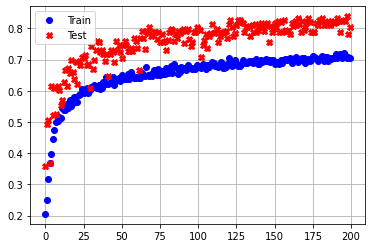

In [ ]:
import numpy as np
print('Train Accuracy: ',np.round(history.history['accuracy'][-1],2))
print('Test_Accuracy: ',np.round(history.history['val_accuracy'][-1],2))

# Plot the accuracy curves
plt.plot(history.history['accuracy'],'bo')
plt.plot(history.history['val_accuracy'],'rX')
plt.grid()
plt.legend(['Train','Test'])

pred_probabilities= model.predict(test)

print('First Five Probs.:\n',pred_probabilities[0:5])

print('\n\nFirst Five Classes:\n',onehot_test[0:5])

In [ ]:
base_model = keras.applications.resnet50.ResNet50(
    include_top=False, weights=None,
    input_shape=(224,224,3))
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(5, activation= 'softmax')(x)
model = keras.Model(inputs = base_model.input, outputs = predictions)
model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])
# validation_data allows to see evaluation on test while training
history1=model.fit(train, onehot_train,
         epochs=200,
         batch_size=128,
         validation_data=(test, onehot_test),
         verbose=1)
print('Train Accuracy: ',np.round(history1.history['accuracy'][-1],2))
print('Test_Accuracy: ',np.round(history1.history['val_accuracy'][-1],2))

Epoch 1/200
20/20 [==============================] - 19s 699ms/step - loss: 1.8314 - accuracy: 0.5159 - val_loss: 16.6948 - val_accuracy: 0.1541
Epoch 2/200
20/20 [==============================] - 12s 625ms/step - loss: 0.3506 - accuracy: 0.8676 - val_loss: 7.2624 - val_accuracy: 0.2007
Epoch 3/200
20/20 [==============================] - 12s 626ms/step - loss: 0.1147 - accuracy: 0.9651 - val_loss: 12.7447 - val_accuracy: 0.2007
Epoch 4/200
20/20 [==============================] - 12s 623ms/step - loss: 0.1345 - accuracy: 0.9600 - val_loss: 11.3967 - val_accuracy: 0.2007
Epoch 5/200
20/20 [==============================] - 12s 623ms/step - loss: 0.0422 - accuracy: 0.9868 - val_loss: 13.5028 - val_accuracy: 0.2007
Epoch 6/200
20/20 [==============================] - 12s 624ms/step - loss: 0.1576 - accuracy: 0.9560 - val_loss: 16.9736 - val_accuracy: 0.2007
Epoch 7/200
20/20 [==============================] - 12s 623ms/step - loss: 0.0412 - accuracy: 0.9843 - val_loss: 18.7784 - val_acc

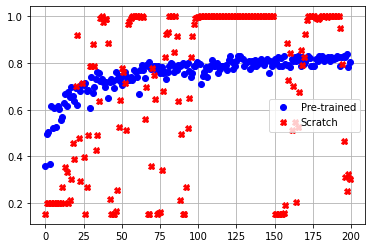

In [ ]:
# Plot the accuracy curves
plt.plot(history.history['val_accuracy'],'bo')
plt.plot(history1.history['val_accuracy'],'rX')
plt.grid()
plt.legend(['Pre-trained','Scratch'])